In [2]:
%reset -f

In [3]:
#import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix, log_loss

# Load the new dataset for bank churn analysis
file_path = 'BankChurners.csv'
bank_data = pd.read_csv(file_path)

#Drop as instructed

bank_data = bank_data.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                            'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],axis=1)

# Get Column Names
column_names = bank_data.columns
column_names

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

### EDA of top 75% of people who are likely to owe us money

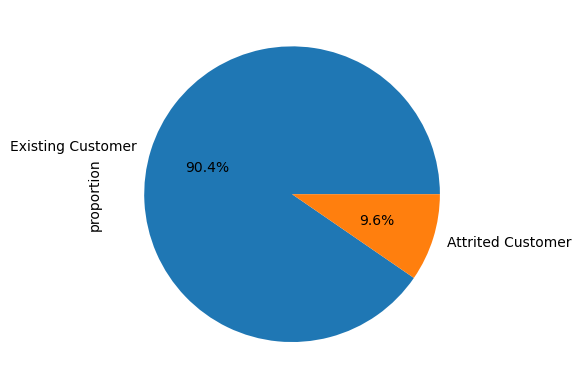

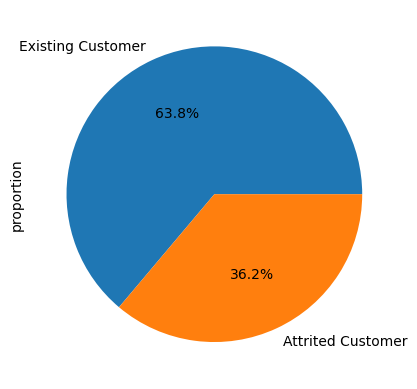

CLIENTNUM                   1914
Attrition_Flag              1914
Customer_Age                1914
Gender                      1914
Dependent_count             1914
Education_Level             1914
Marital_Status              1914
Income_Category             1914
Card_Category               1914
Months_on_book              1914
Total_Relationship_Count    1914
Months_Inactive_12_mon      1914
Contacts_Count_12_mon       1914
Credit_Limit                1914
Total_Revolving_Bal         1914
Avg_Open_To_Buy             1914
Total_Amt_Chng_Q4_Q1        1914
Total_Trans_Amt             1914
Total_Trans_Ct              1914
Total_Ct_Chng_Q4_Q1         1914
Avg_Utilization_Ratio       1914
dtype: int64

In [4]:
### Get distribition of Total_Reovling_Bal
#plt.hist(bank_data['Total_Revolving_Bal'], bins=50)
#plt.show()

# Trim all 0 from Total_Revolving_Bal
bank_data_EDA = bank_data[bank_data['Total_Revolving_Bal'] > 0]
bank_data_Zeros = bank_data[bank_data['Total_Revolving_Bal'] == 0]
#plt.hist(bank_data_EDA['Total_Revolving_Bal'], bins=50)
#plt.show()

# Get distrib of target variable as percentage
bank_data_EDA['Attrition_Flag'].value_counts(normalize=True).plot(kind='pie', autopct='%.1f%%')
plt.show()
bank_data_Zeros['Attrition_Flag'].value_counts(normalize=True).plot(kind='pie', autopct='%.1f%%')
plt.show()

# get only the data that make up the top 25% of Total_Revolving_Bal
bank_data = bank_data_EDA[bank_data_EDA['Total_Revolving_Bal'] > bank_data_EDA['Total_Revolving_Bal'].quantile(0.75)]
bank_data_25 = bank_data_EDA[bank_data_EDA['Total_Revolving_Bal'] <= bank_data_EDA['Total_Revolving_Bal'].quantile(0.75)]
bank_data.count()

### Skew Analysis

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# First, let's identify numerical columns and calculate skewness for each
numerical_cols = bank_data.select_dtypes(include=['int64', 'float64']).columns
skewness = bank_data[numerical_cols].skew()
# print(skewness)

# Now, let's find columns with skewness greater than 1 or less than -1 which indicates significant skewness
skewed_cols = skewness[(skewness > 1) | (skewness < -1)].index

# # Create distribution plots for skewed columns
# for col in skewed_cols:
#     plt.figure(figsize=(8, 4))
#     sns.histplot(bank_data[col], kde=True)
#     plt.title(f'Distribution of {col} (Skewness: {skewness[col]:.2f})')
#     plt.xlabel(col)
#     plt.ylabel('Frequency')
#     plt.show()


In [6]:
# Hyperparameters are set lower than usual as dataset is small and overfitting is a concern
# max_depth default of 6 is causing overfitting

max_depth = 3
learning_rate = 0.1
n_estimators = 100
random_state = 42
test_size = 0.2


### Quick Summary of Metrics
Accuracy measures the overall correctness of the model's predictions (the number of correct predictions divided by the total number of predictions). High accuracy on both training and test sets suggests that the model is performing well, but it's always important to consider this metric in the context of the problem's baseline accuracy and the balance of classes in your dataset.

F1 Score is the harmonic mean of precision and recall. It's particularly useful for evaluating models on imbalanced datasets. A high F1 score indicates that the model has a good balance between precision (the model's ability to label negative samples correctly) and recall (the model's ability to find all the positive samples).

ROC AUC (Area Under the Receiver Operating Characteristic Curve) measures the ability of the model to distinguish between the classes. A score closer to 1 indicates that the model has a good measure of separability; it's good at predicting true positives while minimizing false positives.

Log Loss evaluates the accuracy of the probabilistic predictions. It penalizes false classifications more when the model is more confident about its wrong predictions. Lower log loss values are better, indicating higher confidence in the correct predictions.

In [7]:
y = bank_data['Attrition_Flag'].apply(lambda x: 1 if "Attrited Customer" == x else 0)

bank_data_encoded = pd.DataFrame()

label_encoder = LabelEncoder()
for col_name in bank_data:
    if bank_data[col_name].dtype != 'int64' and bank_data[col_name].dtype != 'float64':
        bank_data[col_name+"_encoded"] = label_encoder.fit_transform(bank_data[col_name])
        bank_data_encoded[col_name+"_encoded"] = bank_data[col_name+"_encoded"]
    else:
        bank_data_encoded[col_name] = bank_data[col_name]

X = bank_data_encoded.drop(['Attrition_Flag_encoded','CLIENTNUM'],axis=1)

C:\Users\derek\AppData\Local\Temp\ipykernel_26304\1890642247.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bank_data[col_name+"_encoded"] = label_encoder.fit_transform(bank_data[col_name])
C:\Users\derek\AppData\Local\Temp\ipykernel_26304\1890642247.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bank_data[col_name+"_encoded"] = label_encoder.fit_transform(bank_data[col_name])
C:\Users\derek\AppData\Local\Temp\ipykernel_26304\1890642247.py:8: SettingWithCopyWarning: 
A value is trying to be set on

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)

xgb_classifier = xgb.XGBClassifier(random_state=random_state,eval_metric='logloss',use_label_encoder=False,
                                   max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators,verbosity=0,objective='binary:logistic')
xgb_classifier.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

y_train_pred = xgb_classifier.predict(X_train)
y_test_pred = xgb_classifier.predict(X_test)



train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
logloss_result = xgb_classifier.evals_result()
train_logloss_last = logloss_result['validation_0']['logloss'][-1]
test_logloss_last = logloss_result['validation_1']['logloss'][-1]
# Calculate Lift Score

print(f"""Data Pre-Normalization:
      Train Accuracy: {train_accuracy*100:.2f}%
      Test Accuracy: {test_accuracy*100:.2f}%
      F1 Score: {f1*100:.2f}%
        Recall: {recall*100:.2f}%
        Precision: {precision*100:.2f}%
      ROC AUC: {roc_auc*100:.2f}%
      Train Log Loss: {train_logloss_last:.4f}
      Test Log Loss: {test_logloss_last:.4f}""")


Data Pre-Normalization:
      Train Accuracy: 98.95%
      Test Accuracy: 93.47%
      F1 Score: 74.23%
        Recall: 67.92%
        Precision: 81.82%
      ROC AUC: 82.75%
      Train Log Loss: 0.0632
      Test Log Loss: 0.1513


In [9]:
from sklearn.metrics import precision_recall_fscore_support

# Assuming you have already made predictions using your classifier
y_pred = xgb_classifier.predict(X_test)

# Calculate precision and recall for both classes
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)

# Results
print(f"Precision for class 0: {precision[0]*100:.2f}")
print(f"Recall for class 0: {recall[0]*100:.2f}")
print(f"Precision for class 1: {precision[1]*100:.2f}")
print(f"Recall for class 1: {recall[1]*100:.2f}")

Precision for class 0: 94.99
Recall for class 0: 97.58
Precision for class 1: 81.82
Recall for class 1: 67.92


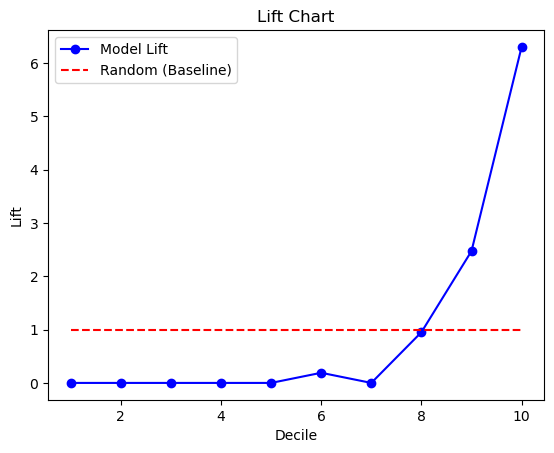

In [10]:


# Example predictions
y_test_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]

# Creating a DataFrame
data = pd.DataFrame({'true': y_test, 'proba': y_test_pred_proba})
data['decile'] = pd.qcut(data['proba'], 10, labels=False)
data.sort_values('proba', ascending=False, inplace=True)
data['cumulative_response'] = data.groupby('decile')['true'].transform(pd.Series.cumsum)
data['cumulative_count'] = data.groupby('decile').cumcount() + 1
data['baseline'] = data['true'].sum() / len(data)
data['lift'] = data['cumulative_response'] / (data['cumulative_count'] * data['baseline'])

# Calculate lift at each decile
lift_at_decile = data.groupby('decile')['lift'].last()

# Plotting
plt.plot(lift_at_decile.index + 1, lift_at_decile, marker='o', linestyle='-', color='b', label='Model Lift')
plt.plot(lift_at_decile.index + 1, np.ones_like(lift_at_decile), color='r', linestyle='--', label='Random (Baseline)')
plt.xlabel('Decile')
plt.ylabel('Lift')
plt.title('Lift Chart')
plt.legend()
plt.show()




### Normalized Data

In [11]:
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew, boxcox
# Apply PowerTransformer to the skewed columns

pt = PowerTransformer()
X_normalized = X.copy()

skewed_cols = skewness[(skewness > 1) | (skewness < -1)].index
# print(skewed_cols)
X_normalized[skewed_cols] = pt.fit_transform(X_normalized[skewed_cols])
X_normalized_train, X_normalized_test, y_train, y_test = train_test_split(X_normalized, y, test_size=test_size, random_state=random_state,shuffle=True)

# for i in skewed_cols:
#     transformed_skew = skew(X_normalized[i])
#     plt.figure(figsize=(8, 4))
#     sns.histplot(X_normalized[i], kde=True)
#     plt.title(f'Distribution of {i} (Skewness: {skew(X_normalized[i]):.2f})')
#     plt.xlabel(i)
#     plt.ylabel('Frequency')
#     plt.show()

xgb_classifier = xgb.XGBClassifier(random_state=random_state,eval_metric='logloss',use_label_encoder=False,
                                   max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators,verbosity=0,objective='binary:logistic')
xgb_classifier.fit(X_normalized_train, y_train, eval_set=[(X_normalized_train, y_train), (X_normalized_test, y_test)], verbose=False)

y_train_pred = xgb_classifier.predict(X_normalized_train)
y_test_pred = xgb_classifier.predict(X_normalized_test)


train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
logloss_result = xgb_classifier.evals_result()
train_logloss_last = logloss_result['validation_0']['logloss'][-1]
test_logloss_last = logloss_result['validation_1']['logloss'][-1]

print(f"""Data Post-Normalization:
      Train Accuracy: {train_accuracy*100:.2f}%
      Test Accuracy: {test_accuracy*100:.2f}%
      F1 Score: {f1*100:.2f}%
            Recall: {recall*100:.2f}%
            Precision: {precision*100:.2f}%
      ROC AUC: {roc_auc*100:.2f}%
      Train Log Loss: {train_logloss_last:.4f}
      Test Log Loss: {test_logloss_last:.4f}""")


KeyError: "['CLIENTNUM'] not in index"

In [ ]:
import pandas as pd
y_test_pred_proba = xgb_classifier.predict_proba(X_normalized_test)[:, 1]

data = pd.DataFrame({'actual': y_test, 'predicted':y_test_pred, 'predicted_proba' :y_test_pred_proba})
data['quintiles'] = pd.qcut(data['predicted_proba'], 5, labels=False)
response_rate = data.groupby('quintiles')['actual'].mean()
overall_response_rate = data['actual'].mean()
# Calculate lift score
lift_score = response_rate / overall_response_rate
lift_score

quintiles
0    0.000000
1    0.000000
2    0.000000
3    0.060399
4    4.931168
Name: actual, dtype: float64

#### Notes:
This shows that there is no real benefit to normalization of the data due to no observable differences.

### Feature Trimming

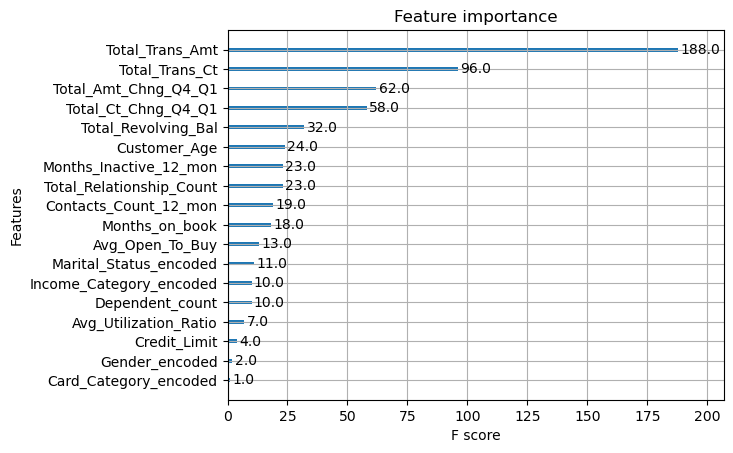

Index(['Customer_Age', 'Gender_encoded', 'Dependent_count',
       'Education_Level_encoded', 'Marital_Status_encoded',
       'Income_Category_encoded', 'Card_Category_encoded', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')


In [ ]:
# Feature selection using XGBoost
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Train the model

xgb_classifier = xgb.XGBClassifier(random_state=random_state,eval_metric='logloss',use_label_encoder=False,
                                   max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators,verbosity=0,objective='binary:logistic')
xgb_classifier.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

plot_importance(xgb_classifier, importance_type='weight')
plt.show()

feature_importance = xgb_classifier.feature_importances_

# Sort by importance

sorted_importance = [x for _, x in sorted(zip(feature_importance, X_train.columns), reverse=True)]
print(X_train.columns)
# Print the feature importance

In [ ]:


def evaluate_model_with_features(features):
    # Train and evaluate the model with the specified features
    X_train_subset = X_train[features]
    X_test_subset = X_test[features]
    
    xgb_classifier = xgb.XGBClassifier(random_state=random_state, eval_metric='logloss', use_label_encoder=False,
                                       max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators,verbosity=0,objective='binary:logistic')
    xgb_classifier.fit(X_train_subset, y_train, eval_set=[(X_train_subset, y_train), (X_test_subset, y_test)], verbose=False)
    
    # Making predictions
    y_train_pred = xgb_classifier.predict(X_train_subset)
    y_test_pred = xgb_classifier.predict(X_test_subset)
    y_train_pred_proba = xgb_classifier.predict_proba(X_train_subset)[:,1]
    y_test_pred_proba = xgb_classifier.predict_proba(X_test_subset)[:,1]
    
    # Calculating metrics
    metrics = {
        'Train Accuracy': accuracy_score(y_train, y_train_pred),
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'F1 Score': f1_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'ROC AUC': roc_auc_score(y_test, y_test_pred),
        'Train Log Loss': log_loss(y_train, y_train_pred_proba),
        'Test Log Loss': log_loss(y_test, y_test_pred_proba)
        # Get inve
    }
    
    return metrics

# Iterating over features and collecting metrics
all_metrics = []
for i in range(1, len(sorted_importance) + 1):
    features = sorted_importance[:i]
    metrics = evaluate_model_with_features(features)
    all_metrics.append(metrics)


c:\Users\derek\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\derek\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Convert the list of dictionaries to a DataFrame
import pandas as pd
metrics_df = pd.DataFrame(all_metrics)
metrics_df.index = range(1, len(sorted_importance) + 1) 
metrics_df.index.name = 'Number of Features'
metrics_df

,Train Accuracy,Test Accuracy,F1 Score,Precision,Recall,ROC AUC,Train Log Loss,Test Log Loss
Number of Features,,,,,,,,
1,0.923764,0.927700,0.000000,0.000000,0.000000,0.500000,0.261970,0.257809
2,0.923764,0.927700,0.000000,0.000000,0.000000,0.500000,0.219233,0.239219
3,0.947070,0.935540,0.393443,0.615385,0.289157,0.637536,0.149283,0.183648
4,0.954912,0.943380,0.480000,0.714286,0.361446,0.675089,0.125298,0.170731
5,0.959268,0.939895,0.510638,0.620690,0.433735,0.706539,0.116458,0.165218
6,0.977129,0.959059,0.671329,0.800000,0.578313,0.783523,0.065268,0.102071
7,0.979743,0.959059,0.671329,0.800000,0.578313,0.783523,0.061716,0.101388
8,0.982139,0.966028,0.723404,0.879310,0.614458,0.803943,0.054895,0.093467
9,0.983882,0.963415,0.704225,0.847458,0.602410,0.796979,0.053773,0.092641


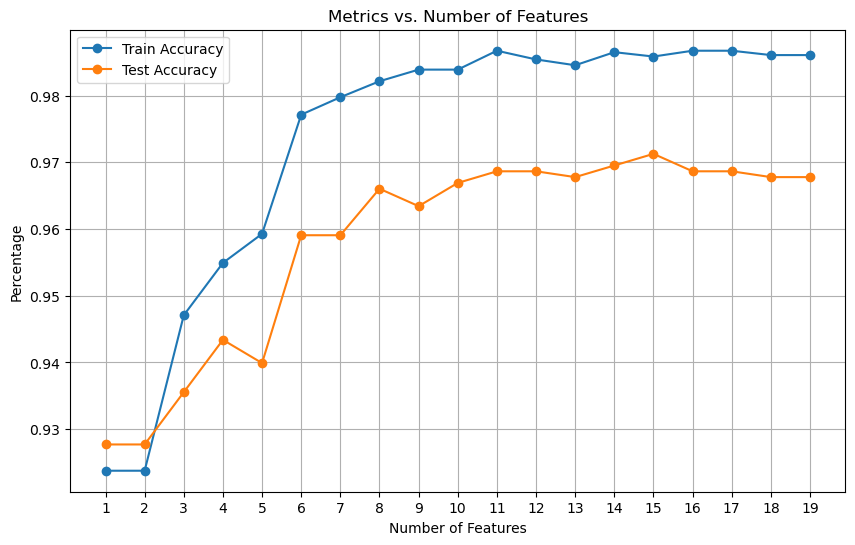

In [ ]:
# Example plot for Test Accuracy
plt.figure(figsize=(10, 6))
train_accurracies = [m['Train Accuracy'] for m in all_metrics]
test_accuracies = [m['Test Accuracy'] for m in all_metrics]
plt.plot(range(1, len(sorted_importance) + 1), train_accurracies, marker='o', label='Train Accuracy')
plt.plot(range(1, len(sorted_importance) + 1), test_accuracies, marker='o', label='Test Accuracy')
plt.xticks(range(1, len(sorted_importance) + 1))
plt.grid(True)
plt.xlabel('Number of Features')
plt.ylabel('Percentage')
plt.title('Metrics vs. Number of Features')
plt.legend()
plt.show()


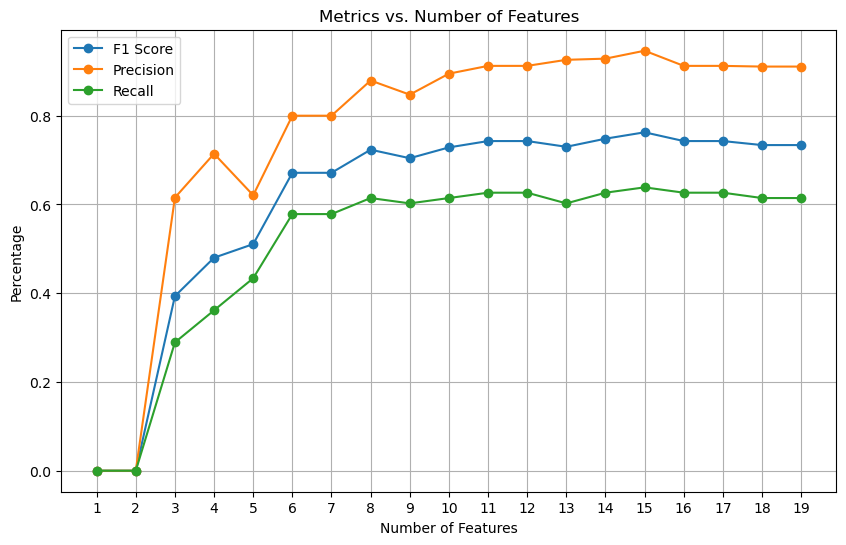

In [ ]:
# Plot F1, Precision, Recall
plt.figure(figsize=(10, 6))
f1_scores = [m['F1 Score'] for m in all_metrics]
precision_scores = [m['Precision'] for m in all_metrics]
recall_scores = [m['Recall'] for m in all_metrics]
plt.plot(range(1, len(sorted_importance) + 1), f1_scores, marker='o', label='F1 Score')
plt.plot(range(1, len(sorted_importance) + 1), precision_scores, marker='o', label='Precision')
plt.plot(range(1, len(sorted_importance) + 1), recall_scores, marker='o', label='Recall')
plt.xticks(range(1, len(sorted_importance) + 1))
plt.grid(True)
plt.xlabel('Number of Features')
plt.ylabel('Percentage')
plt.title('Metrics vs. Number of Features')
plt.legend()
plt.show()



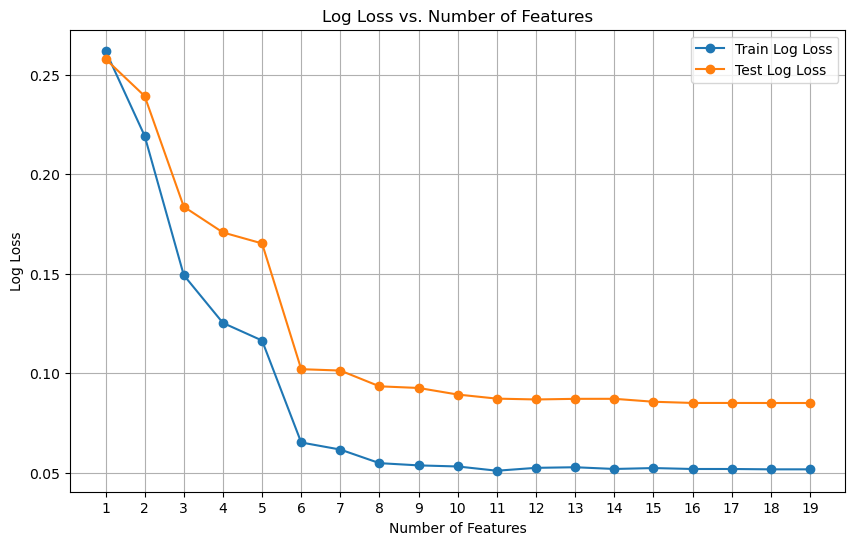

In [ ]:
# Plot for Inverse Log Loss
plt.figure(figsize=(10, 6))
train_log_losses = [m['Train Log Loss'] for m in all_metrics]
test_log_losses = [m['Test Log Loss'] for m in all_metrics]
plt.plot(range(1, len(sorted_importance) + 1), train_log_losses, marker='o', label='Train Log Loss')
plt.plot(range(1, len(sorted_importance) + 1), test_log_losses, marker='o', label='Test Log Loss')
plt.xticks(range(1, len(sorted_importance) + 1))
plt.grid(True)
plt.xlabel('Number of Features')
plt.ylabel('Log Loss')
plt.title('Log Loss vs. Number of Features')
plt.legend()
plt.show()



#### Notes:
Feature selection seems to suggest having 8 features is the most efficient, any other than that and returns will start diminishing,

Model tends to overfit over 12

## Trim down to only top 15 features and retrain

In [ ]:

# Trim data down to top 5 features
top_features = sorted_importance[:8]
X_trim = X.copy()
X_trim = X_trim[top_features]
X_trim_train, X_trim_test, y_train, y_test = train_test_split(X_trim, y, test_size=test_size, random_state=random_state, shuffle=True)
xgb_classifier = xgb.XGBClassifier(random_state=random_state,eval_metric='logloss',use_label_encoder=False,
                                   max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators,verbosity=0,objective='binary:logistic')
xgb_classifier.fit(X_trim_train, y_train, eval_set=[(X_trim_train, y_train), (X_trim_test, y_test)], verbose=False)

y_train_pred = xgb_classifier.predict(X_trim_train)
y_test_pred = xgb_classifier.predict(X_trim_test)

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)
logloss_result = xgb_classifier.evals_result()
train_logloss_last = logloss_result['validation_0']['logloss'][-1]
test_logloss_last = logloss_result['validation_1']['logloss'][-1]

print(f"""Data Pre-Normalization - Top 15 Features:
      Train Accuracy: {train_accuracy*100:.2f}%
      Test Accuracy: {test_accuracy*100:.2f}%
      F1 Score: {f1*100:.2f}%
      Precision: {precision*100:.2f}%
      Recall: {recall*100:.2f}%
      ROC AUC: {roc_auc*100:.2f}%
      Train Log Loss: {train_logloss_last:.4f}
      Test Log Loss: {test_logloss_last:.4f}""")


TypeError: 'list' object cannot be interpreted as an integer

In [ ]:
# Reset to original setting

# max_depth = 4 overfits 99% of the time
X_train, X_test, y_train, y_test = train_test_split(X_trim, y, test_size=test_size, random_state=random_state, shuffle=True)
# loop for different learning_rate and n_estimators

learning_rates = []
for i in np.arange(0.1,0.6,0.1):
    learning_rates.append(i)
    
n_estimators = []
for i in np.arange(100,600,100):
    n_estimators.append(i)

results = {}
for max_d in [2,3]:
    for lr in learning_rates:
        for n_est in n_estimators:
            xgb_classifier = xgb.XGBClassifier(random_state=random_state,eval_metric='logloss',use_label_encoder=False,
                                            max_depth=max_d,learning_rate=lr,n_estimators=n_est,verbosity=0,objective='binary:logistic')
            xgb_classifier.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
            y_train_pred = xgb_classifier.predict(X_train)
            y_test_pred = xgb_classifier.predict(X_test)
            y_test_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]
            train_accuracy = accuracy_score(y_train, y_train_pred)
            test_accuracy = accuracy_score(y_test, y_test_pred)
            f1 = f1_score(y_test, y_test_pred)
            roc_auc = roc_auc_score(y_test, y_test_pred)
            precision = precision_score(y_test, y_test_pred)
            recall = recall_score(y_test, y_test_pred)
            logloss_result = xgb_classifier.evals_result()
            train_logloss_last = logloss_result['validation_0']['logloss'][-1]
            test_logloss_last = logloss_result['validation_1']['logloss'][-1]
            results[(max_d,lr, n_est)] = {
                'Train Accuracy': train_accuracy,
                'Test Accuracy': test_accuracy,
                'F1 Score': f1,
                'Precision': precision,
                'Recall': recall,
                'ROC AUC': roc_auc,
                'Train Log Loss': train_logloss_last,
                'Test Log Loss': test_logloss_last
            }
results_df = pd.DataFrame(results).T
results_df.index.names = ['Max Depth','Learning Rate', 'N Estimators']
results_df['Accuracy_Diff'] = results_df['Train Accuracy'] - results_df['Test Accuracy']
results_df['Log_Loss_Diff'] = results_df['Train Log Loss'] - results_df['Test Log Loss']
results_df



Train Accuracy  Test Accuracy  F1 Score  \
Max Depth Learning Rate N Estimators                                            
2         0.1           100                 0.973862       0.959059  0.629921   
                        200                 0.984317       0.972125  0.774648   
                        300                 0.987584       0.974739  0.805369   
                        400                 0.990416       0.973868  0.802632   
                        500                 0.993248       0.975610  0.818182   
          0.2           100                 0.984535       0.976481  0.813793   
                        200                 0.990198       0.972125  0.789474   
                        300                 0.994772       0.971254  0.789809   
                        400                 0.997822       0.969512  0.779874   
                        500                 0.999564       0.972125  0.802469   
          0.3           100                 0.989545       0.973868  0.800000   
                        200                 0.995861       0.970383  0.787500   
                        300                 0.998911       0.968641  0.777778   
                        400                 0.999782       0.969512  0.782609   
                        500                 1.000000       0.968641  0.777778   
          0.4           100                 0.992376       0.972997  0.794702   
                        200                 0.997822       0.969512  0.782609   
                        300                 1.000000       0.969512  0.782609   
                        400                 1.000000       0.969512  0.785276   
                        500                 1.000000       0.966028  0.763636   
          0.5           100                 0.994555       0.969512  0.774194   
                        200                 0.999564       0.966899  0.768293   
                        300                 1.000000       0.968641  0.777778   
                        400                 1.000000       0.966899  0.762500   
                        500                 1.000000       0.964286  0.742138   
3         0.1           100                 0.985842       0.971254  0.762590   
                        200                 0.993030       0.973868  0.797297   
                        300                 0.997168       0.972125  0.792208   
                        400                 0.998693       0.972125  0.797468   
                        500                 1.000000       0.971254  0.789809   
          0.2           100                 0.993901       0.971254  0.778523   
                        200                 0.999564       0.970383  0.782051   
                        300                 1.000000       0.970383  0.782051   
                        400                 1.000000       0.971254  0.789809   
                        500                 1.000000       0.971254  0.792453   
          0.3           100                 0.996951       0.971254  0.787097   
                        200                 1.000000       0.971254  0.789809   
                        300                 1.000000       0.965157  0.746835   
                        400                 1.000000       0.966028  0.754717   
                        500                 1.000000       0.966899  0.765432   
          0.4           100                 0.998911       0.972997  0.800000   
                        200                 1.000000       0.973868  0.812500   
                        300                 1.000000       0.969512  0.785276   
                        400                 1.000000       0.970383  0.790123   
                        500                 1.000000       0.971254  0.797546   
          0.5           100                 1.000000       0.971254  0.795031   
                        200                 1.000000       0.969512  0.779874   
                        300                 1.000000       0.966899  

In [ ]:
results_df = results_df.sort_values(by =['Recall','Accuracy_Diff','Test Accuracy'],ascending=[True,True,False])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Filter for best results
results_df = results_df[(results_df['Accuracy_Diff'] < 0.02) & (results_df['F1 Score'] > 0.90) & (results_df['Test Accuracy'] > 0.97)]
results_df

,,,Train Accuracy,Test Accuracy,F1 Score,Precision,Recall,ROC AUC,Train Log Loss,Test Log Loss,Accuracy_Diff,Log_Loss_Diff
Max Depth,Learning Rate,N Estimators,,,,,,,,,,


#### Notes:
Seems like F1 Score will not improve beyond 91%, and the best HyperParamers avaliable is set Max_Depth to 3, Learning_Rate to 0.1, and N estimatiors to 200

Recall needs to be priortized as there is no drawback in making a false positive.